In [256]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [257]:
df = pd.read_csv("loan_tap_dataset_logistic_regression.csv")
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# Problem Statment
To build a system that helps a bank decide whether to approve a personal loan for a customer or not.<br>
The system will look at the customer’s details — like income, credit score, past loans, and other information — and try to predict whether the customer is likely to repay the loan fully or not.

If the system thinks the person will repay, the bank can approve the loan.
If not, the bank might reject it or review it more carefully.

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [259]:
#target varible
df['loan_status'].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

Data is imbalance. We will take care of this later.

In [260]:
print(f"Total Number of rows: {df.shape[0]}")
print(f"Total Number of features: {df.shape[1]}")

Total Number of rows: 396030
Total Number of features: 27


In [261]:
#cheking of null values and duplcates
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

There are some null values present in the data.

In [262]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


# UNIVARIATE ANALYSIS

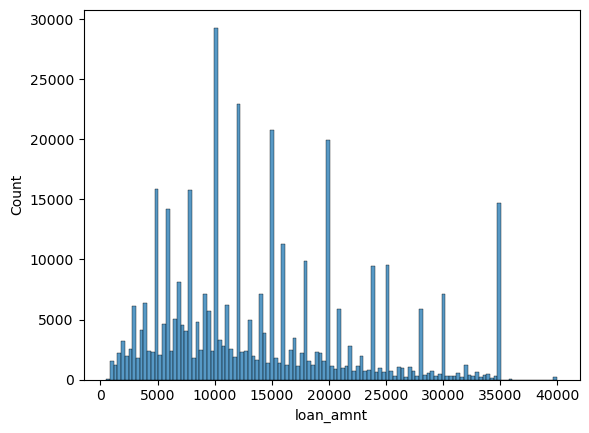

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['loan_amnt'])
plt.show()

<Axes: xlabel='term', ylabel='Count'>

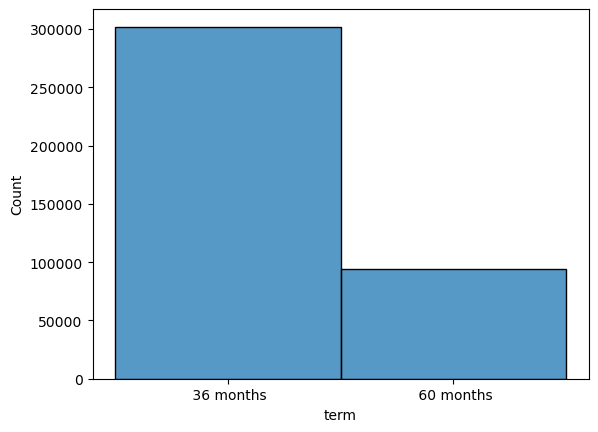

In [264]:
sns.histplot(df['term'])

In [265]:
#term is object. We need to change it's datatype to numerical
df['term'] = df['term'].str.extract(r'(\d)').astype('int')[0]
df['term']

0         3
1         3
2         3
3         3
4         6
         ..
396025    6
396026    3
396027    3
396028    6
396029    3
Name: term, Length: 396030, dtype: int64

In [266]:
df['term'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 396030 entries, 0 to 396029
Series name: term
Non-Null Count   Dtype
--------------   -----
396030 non-null  int64
dtypes: int64(1)
memory usage: 3.0 MB


<Axes: xlabel='term', ylabel='Count'>

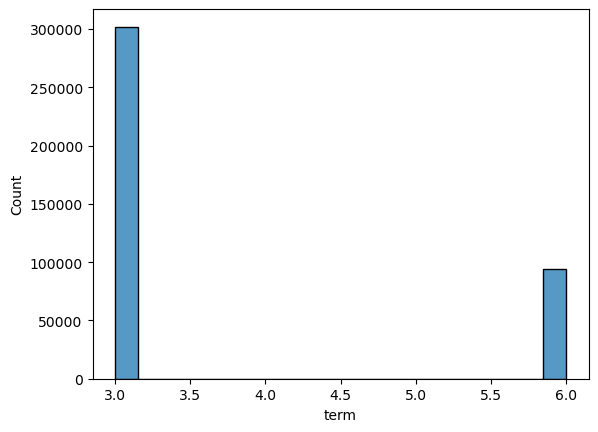

In [267]:
sns.histplot(df['term'])

<Axes: xlabel='int_rate', ylabel='Count'>

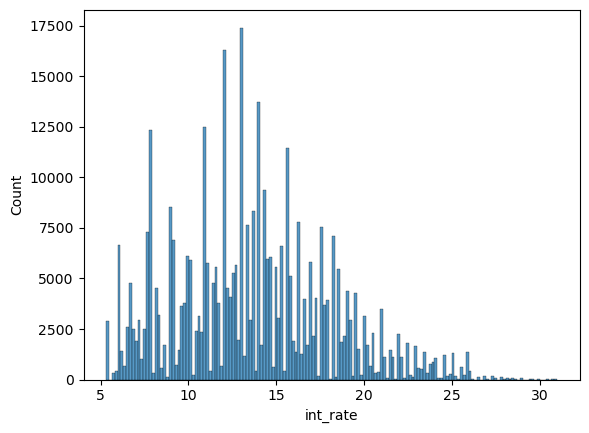

In [268]:
sns.histplot(df['int_rate'])

<Axes: xlabel='installment', ylabel='Count'>

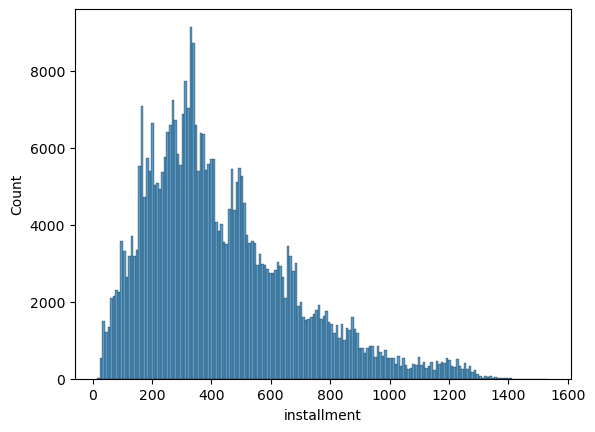

In [269]:
sns.histplot(df['installment'])

<Axes: xlabel='grade', ylabel='Count'>

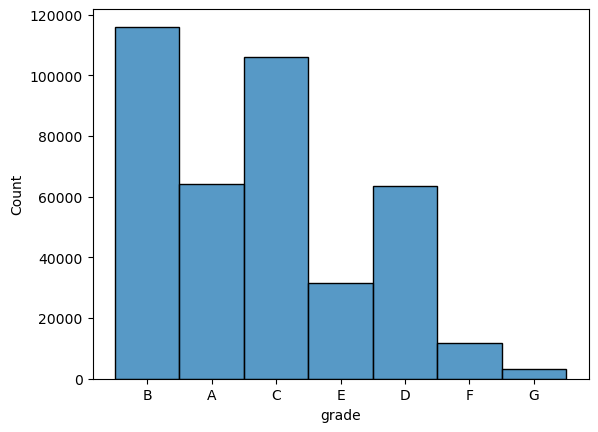

In [270]:
sns.histplot(df['grade'])

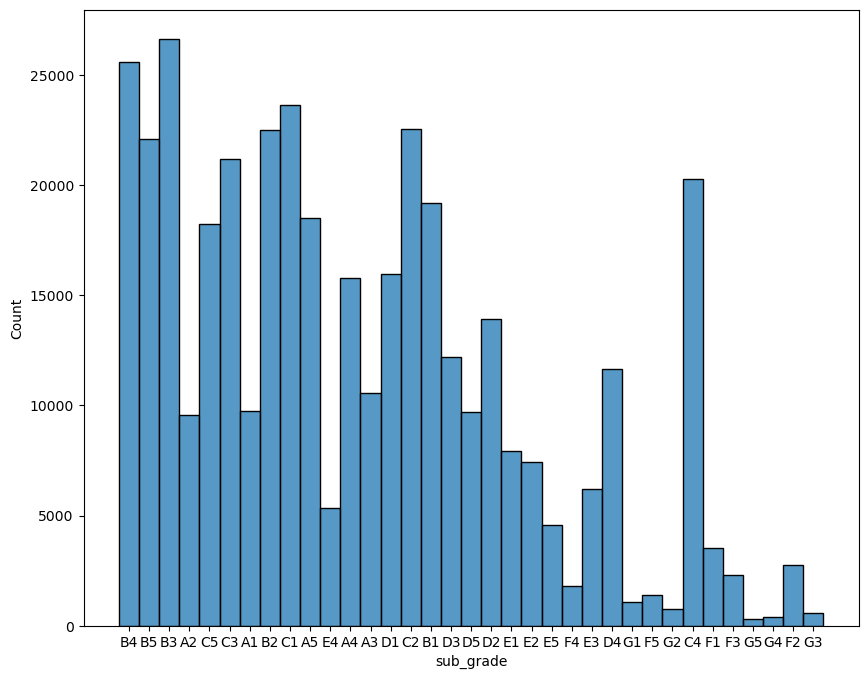

In [271]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
sns.histplot(df['sub_grade'])
plt.show()

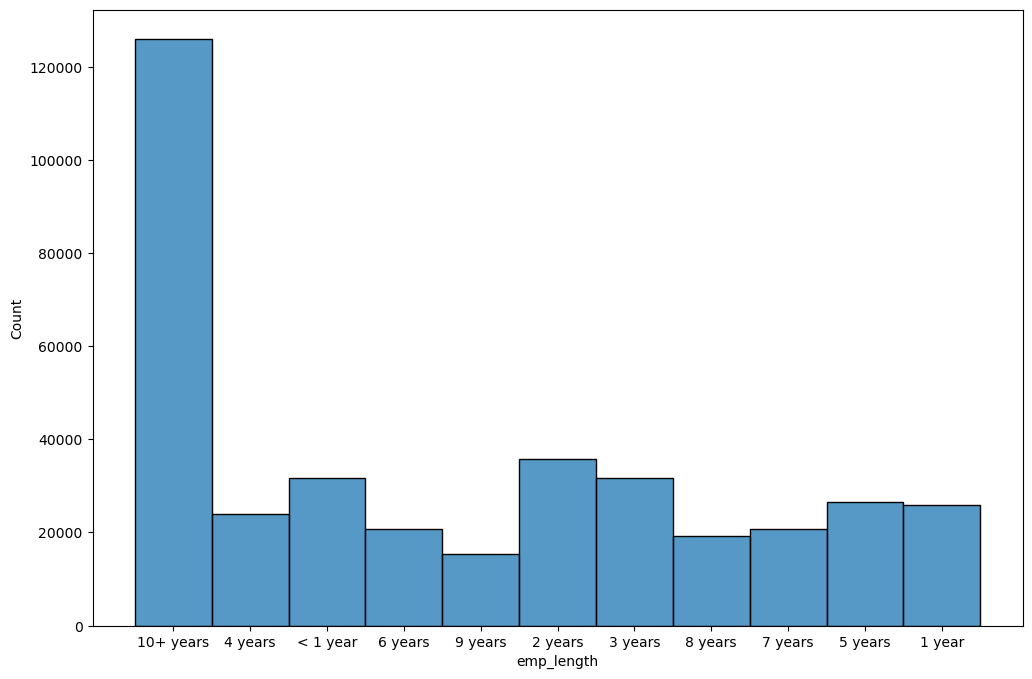

In [272]:
plt.figure(figsize = (12,8))
sns.histplot(df['emp_length'])
plt.show()

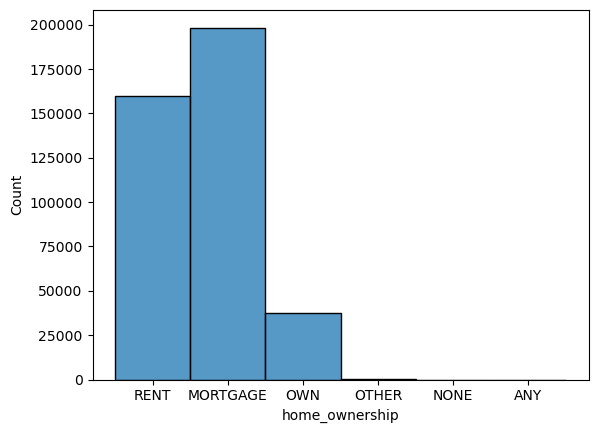

In [273]:
sns.histplot(df['home_ownership'])
plt.show()

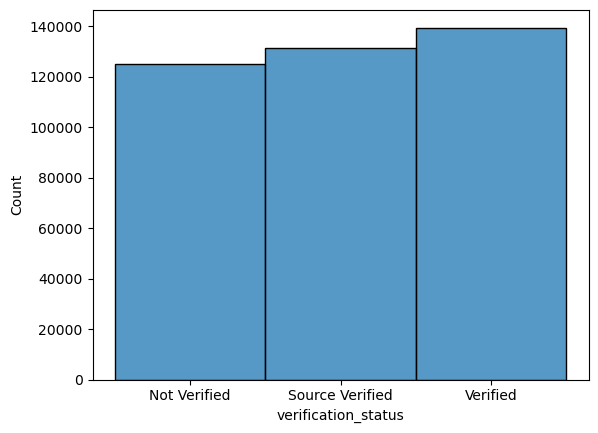

In [274]:
sns.histplot(df['verification_status'])
plt.show()

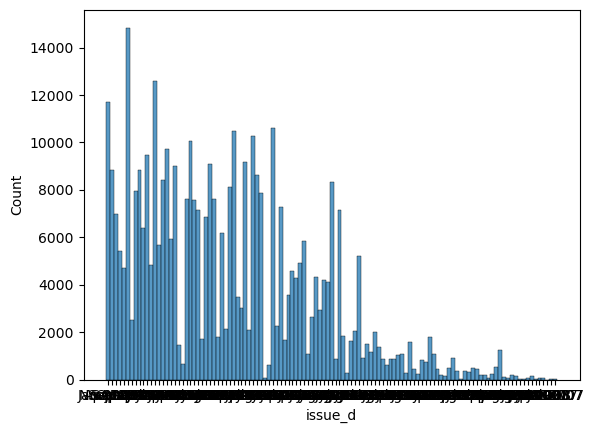

In [275]:
sns.histplot(df['issue_d'])
plt.show()

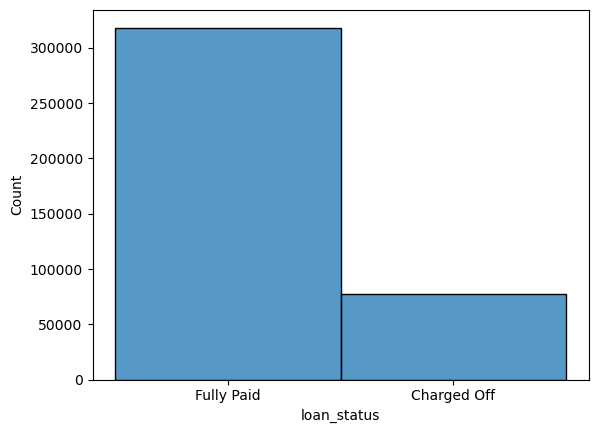

In [276]:
#Target Variable
sns.histplot(df['loan_status'])
plt.show()

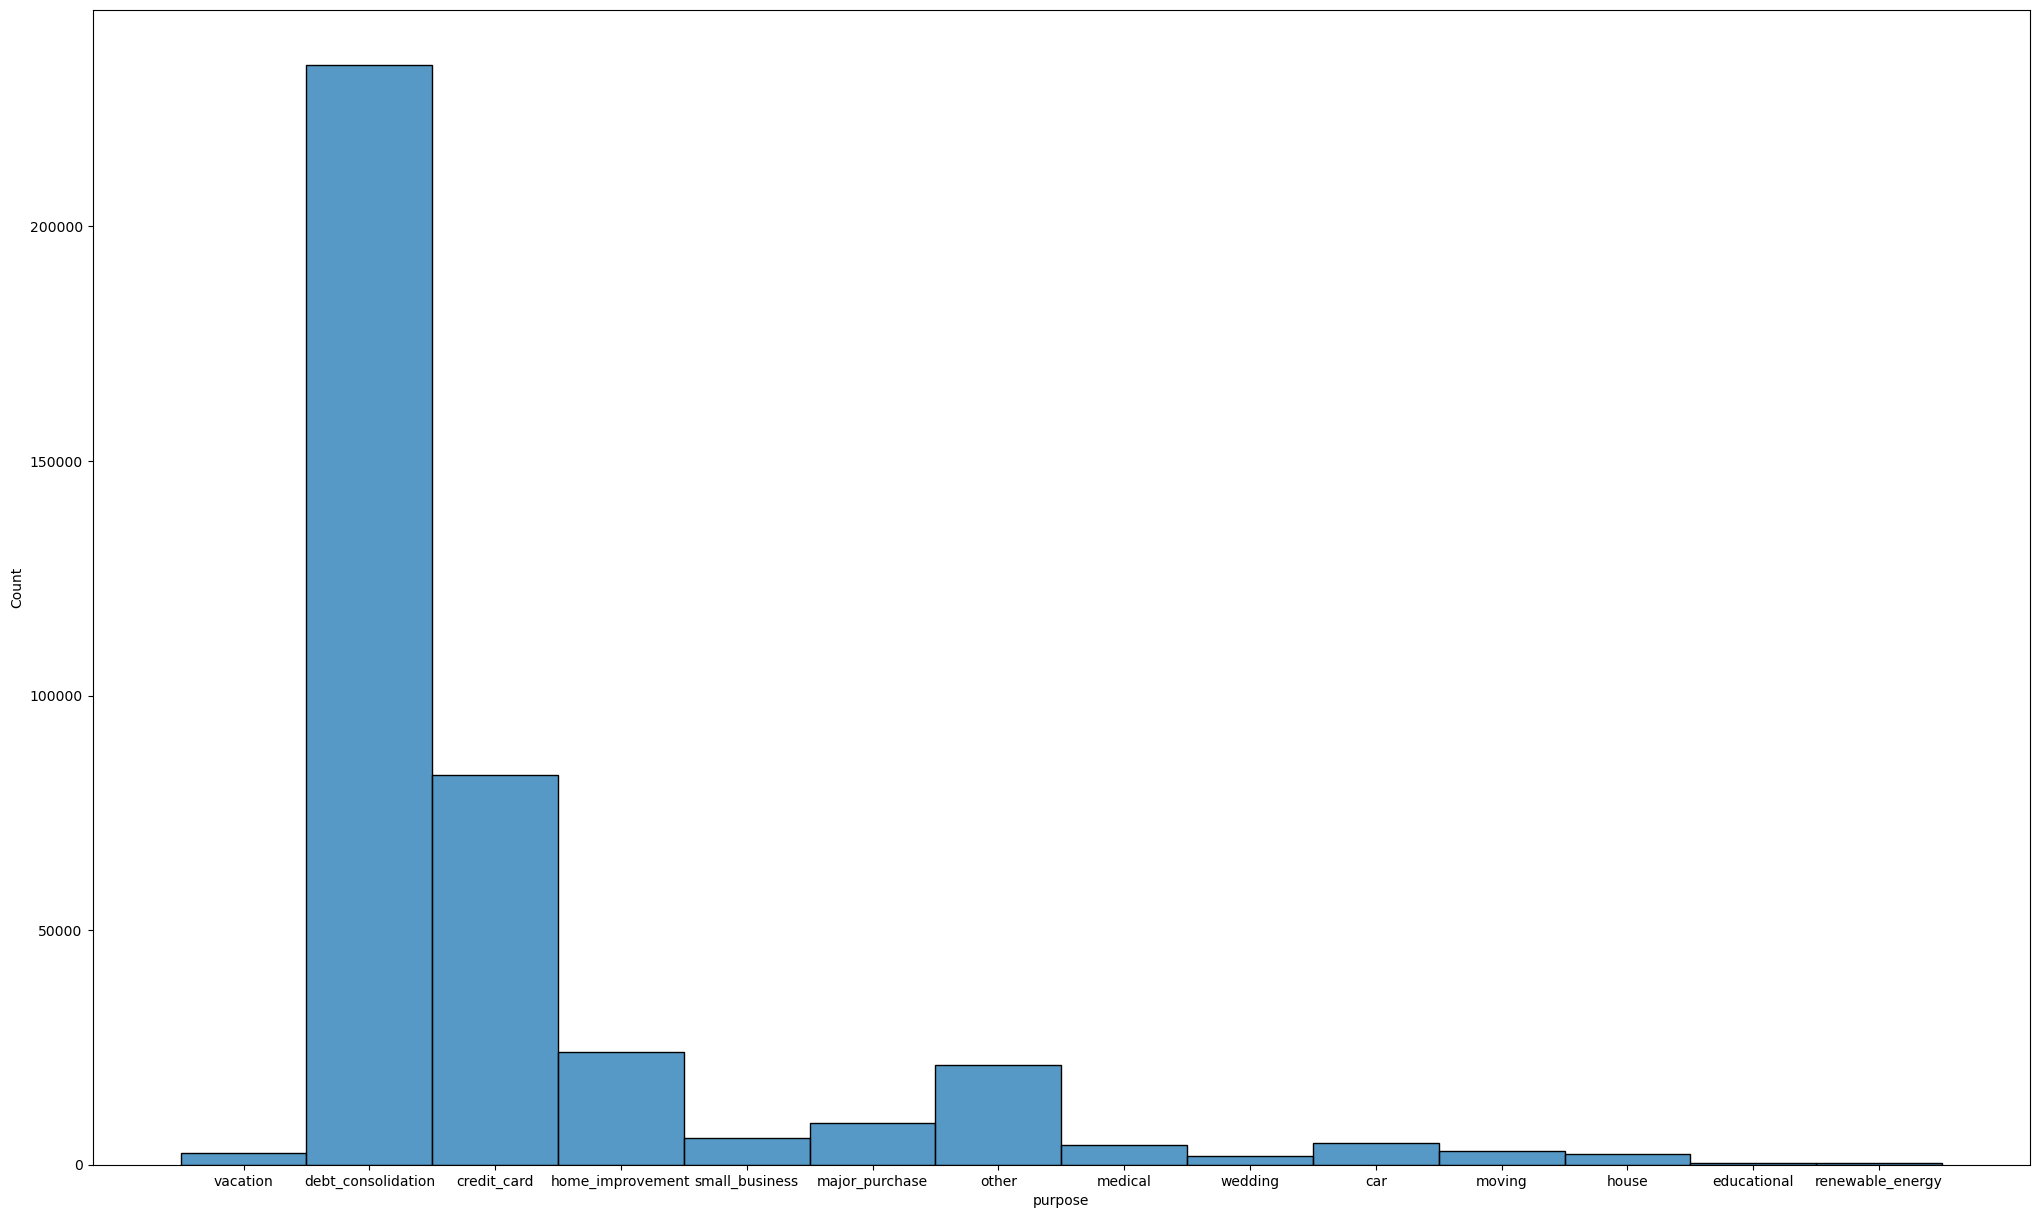

In [277]:
plt.figure(figsize = (25,15))
sns.histplot(df['purpose'])
plt.show()

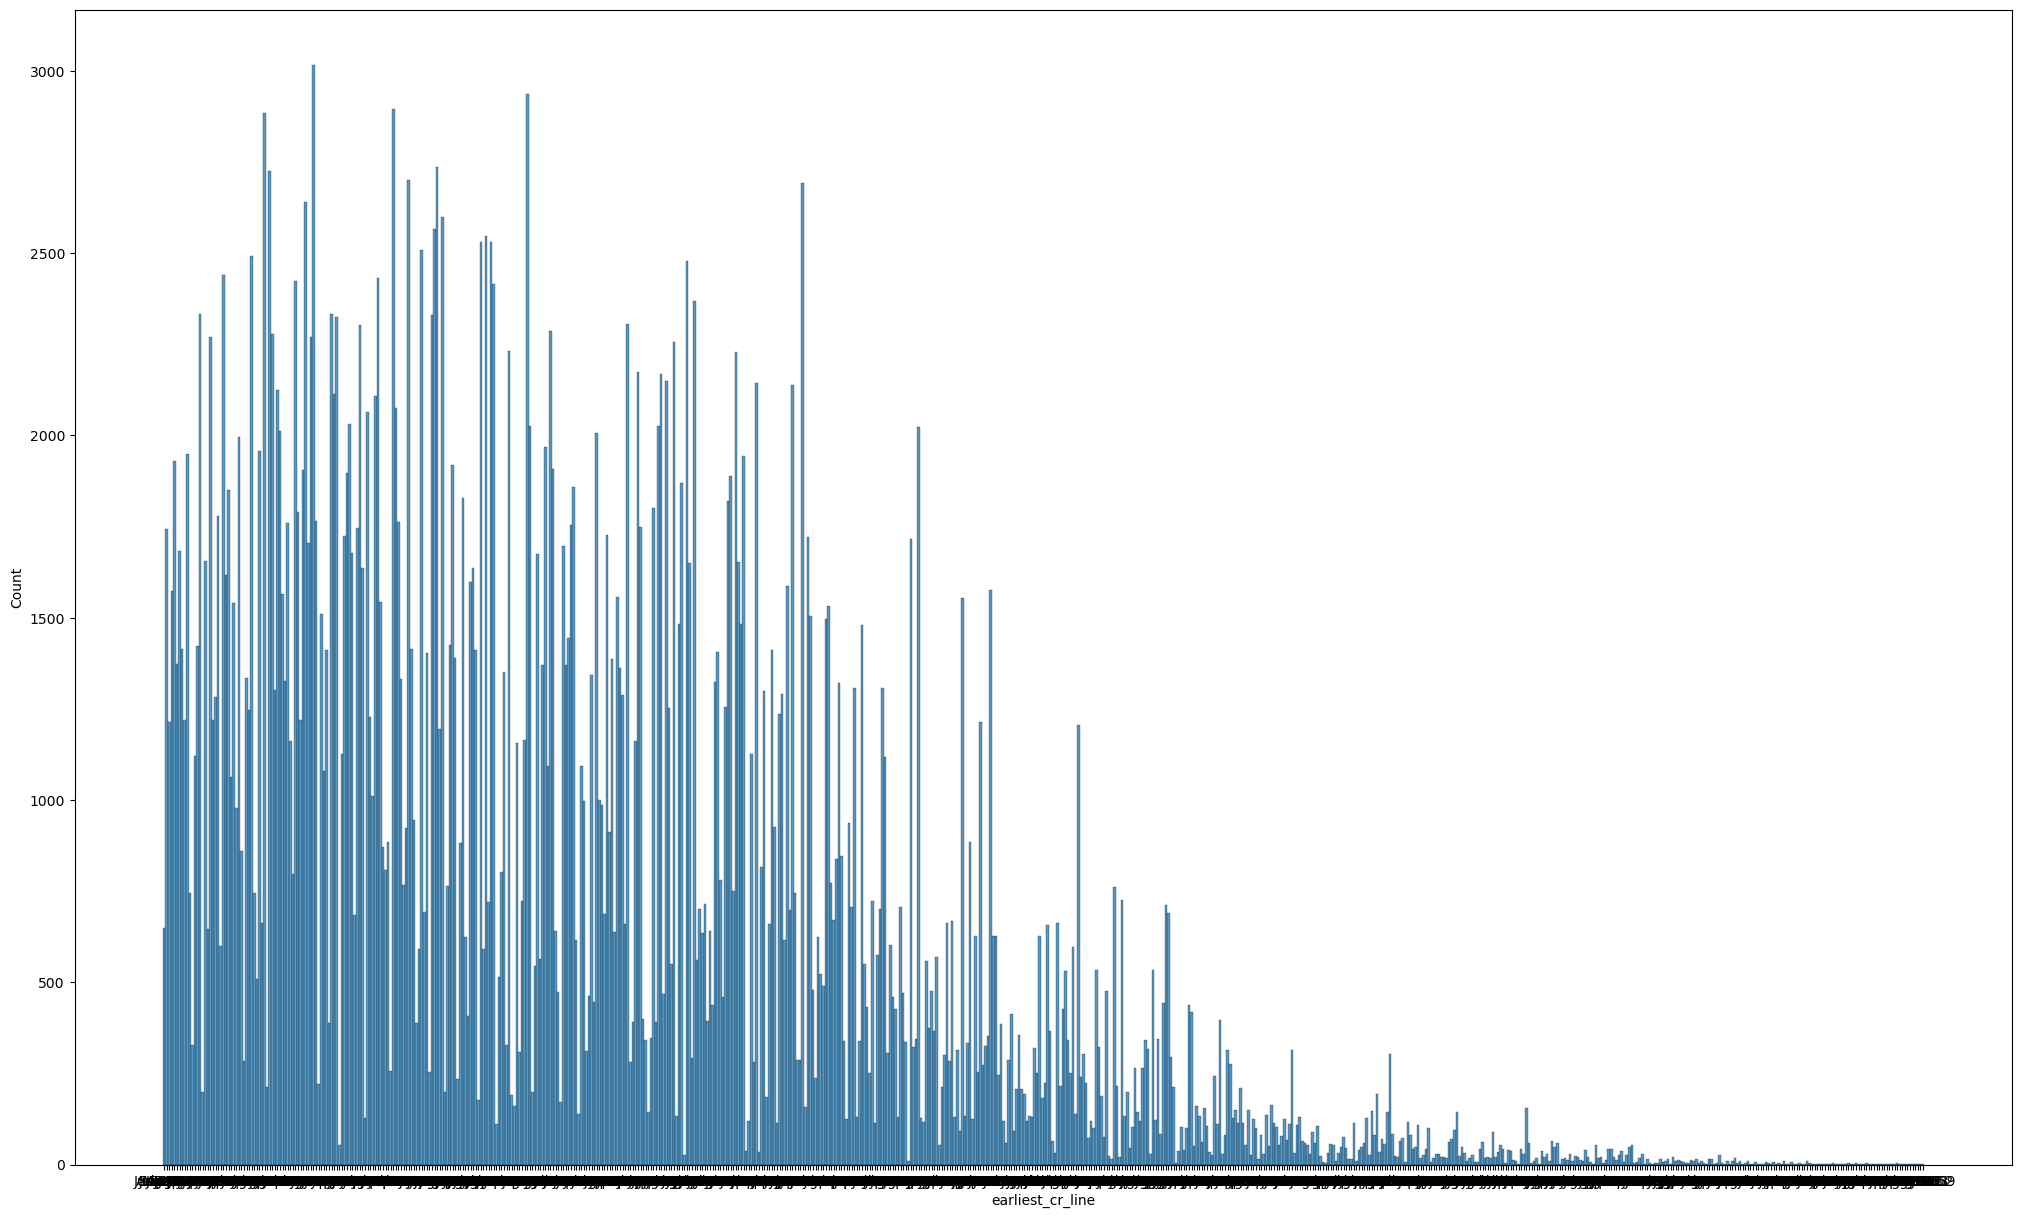

In [278]:
plt.figure(figsize = (25,15))
sns.histplot(df['earliest_cr_line'])
plt.show()

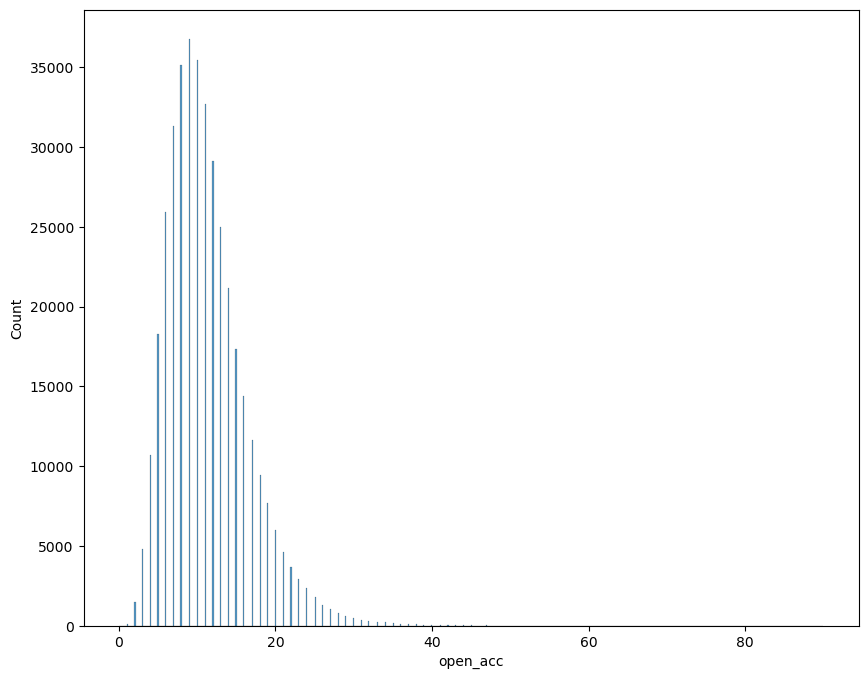

In [279]:
plt.figure(figsize = (10,8))
sns.histplot(df['open_acc'])
plt.show()

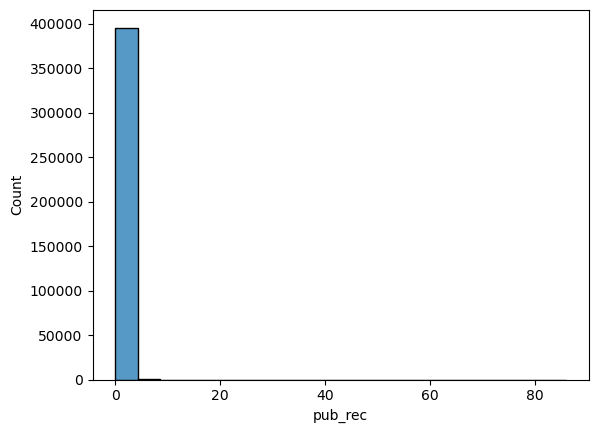

In [280]:
sns.histplot(df['pub_rec'])
plt.show()

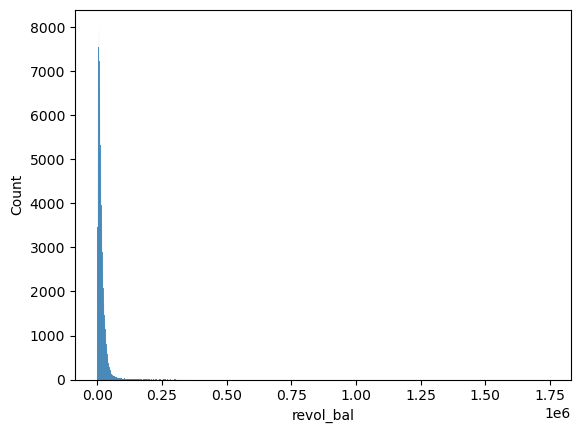

In [281]:
sns.histplot(df['revol_bal'])
plt.show()

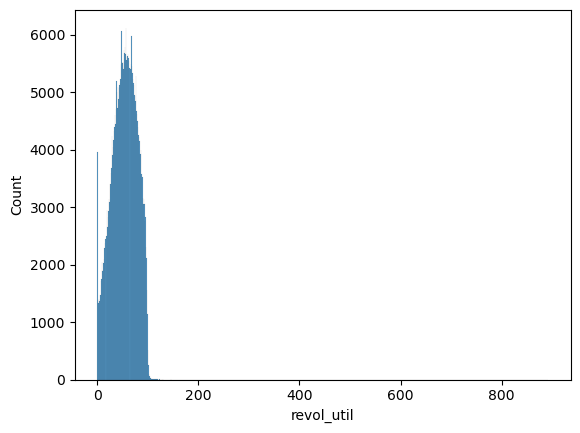

In [282]:
sns.histplot(df['revol_util'])
plt.show()

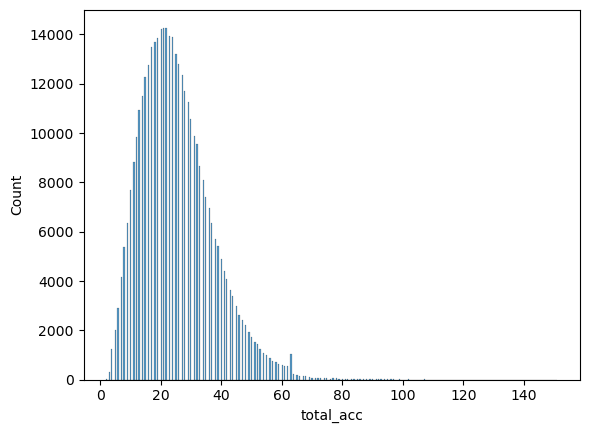

In [283]:
sns.histplot(df['total_acc'])
plt.show()

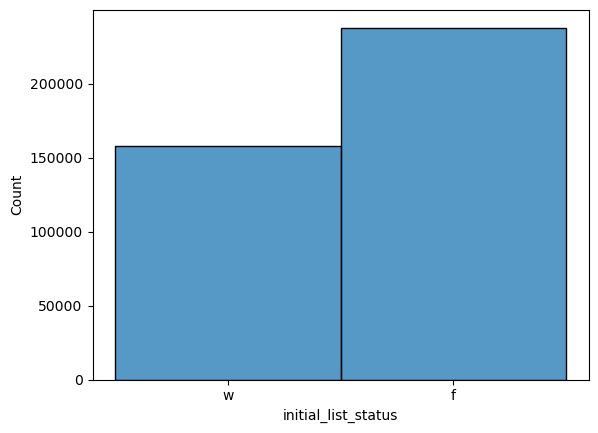

In [284]:
sns.histplot(df['initial_list_status'])
plt.show()

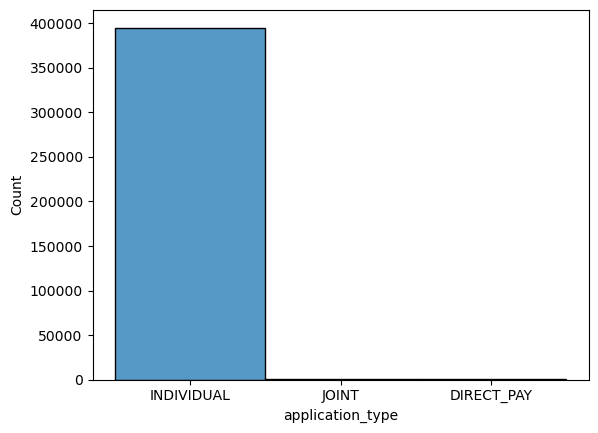

In [285]:
sns.histplot(df['application_type'])
plt.show()

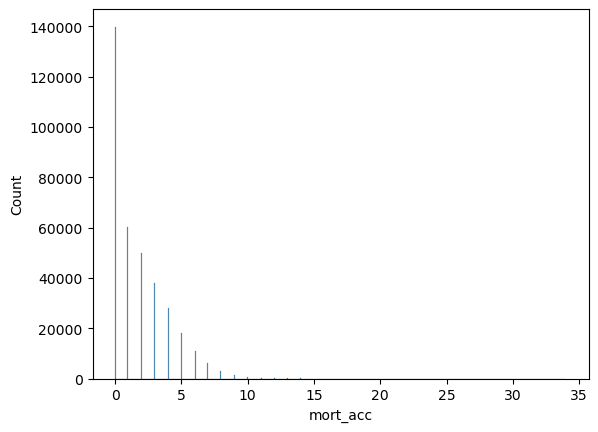

In [286]:
sns.histplot(df['mort_acc'])
plt.show()

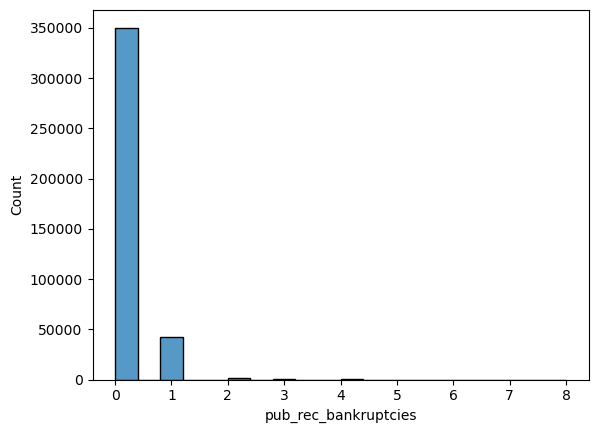

In [287]:
sns.histplot(df['pub_rec_bankruptcies'])
plt.show()

# Bivariate Analysis


In [288]:
#numerical columns 
df.select_dtypes(exclude = 'object').columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

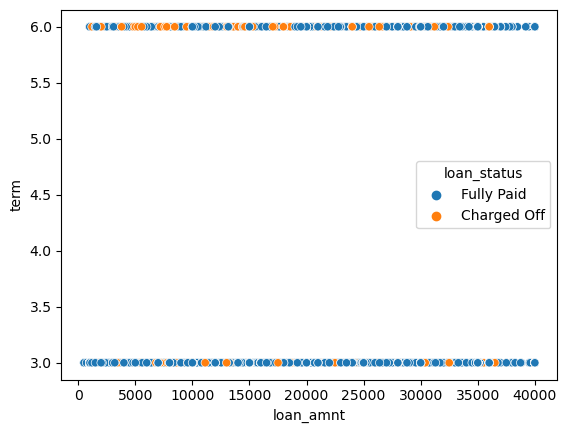

In [289]:
sns.scatterplot(data = df , x = df['loan_amnt'], y = df['term'], hue = 'loan_status')
plt.show()

# There are more charged off values when term is for 60 months than 36 months.

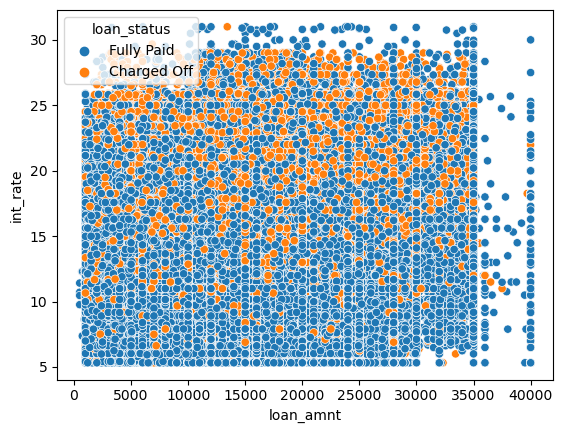

In [290]:
sns.scatterplot(data = df, x = df['loan_amnt'], y = df['int_rate'], hue = 'loan_status')
plt.show()

# When the interest rate is on higher side we are seeing more Charged Off values

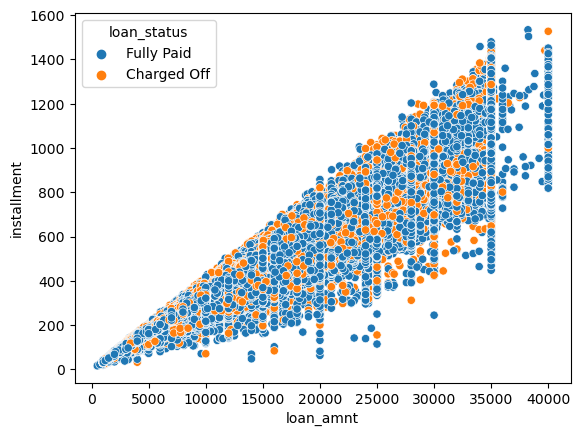

In [291]:
sns.scatterplot(data = df, x = df['loan_amnt'], y = df['installment'], hue = 'loan_status')
plt.show()

# From this we can say that installment is linearly dependent on loan_amount as the amount is increasing no of installments are also increasing. And for the loan status we are not seeing any anamoly here

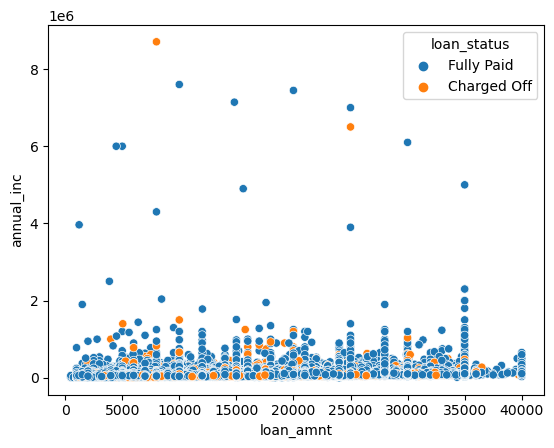

In [292]:
sns.scatterplot(data = df, x = df['loan_amnt'], y = df['annual_inc'], hue = 'loan_status')
plt.show()

# There are some outliers present in this data

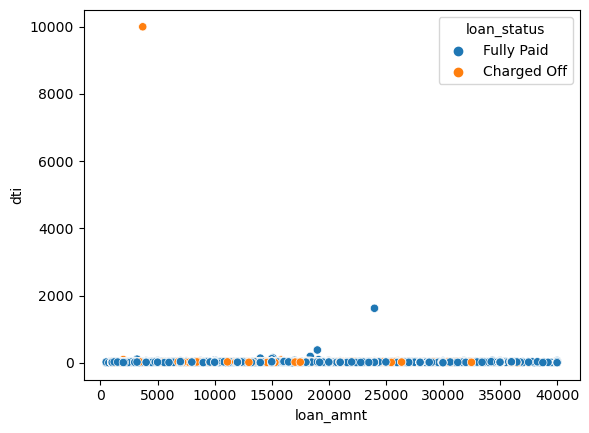

In [293]:
sns.scatterplot(data = df,x = df['loan_amnt'], y = df['dti'], hue = 'loan_status')
plt.show()

# There are very few outliers present in this data

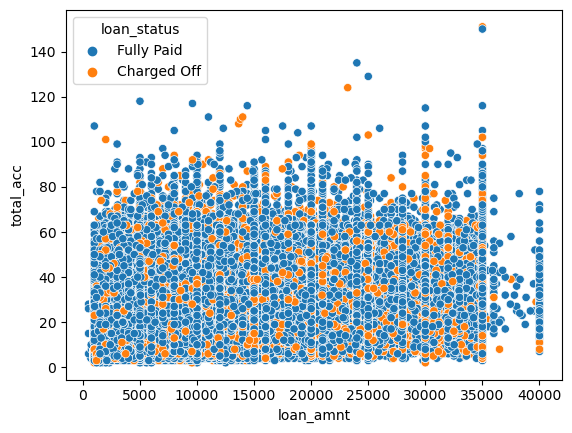

In [294]:
sns.scatterplot(data = df, x = df['loan_amnt'], y = df['total_acc'], hue = 'loan_status')
plt.show()

# Not such important info

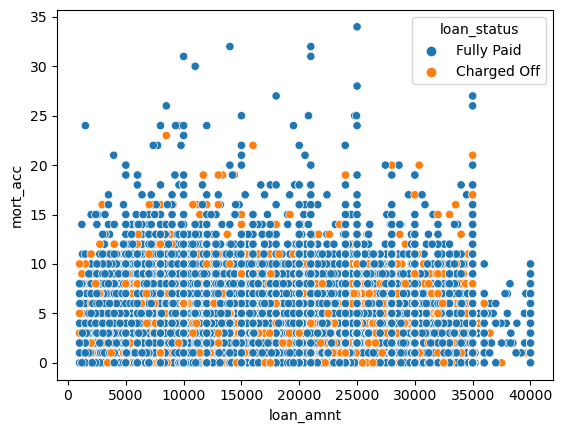

In [295]:
sns.scatterplot(data = df,x = df['loan_amnt'], y = df['mort_acc'], hue = 'loan_status')
plt.show()

# Not such important info

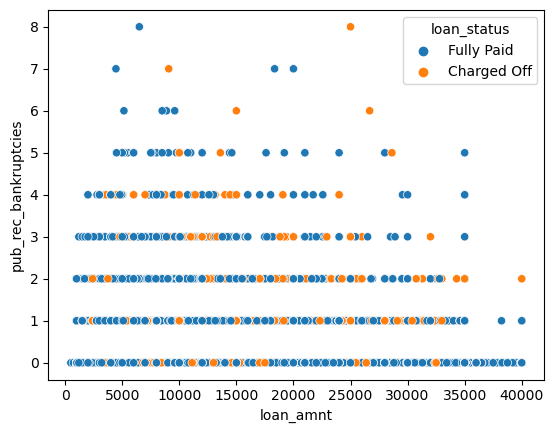

In [296]:
sns.scatterplot(data = df, x = df['loan_amnt'], y = df['pub_rec_bankruptcies'], hue = 'loan_status')
plt.show()

# There is no such pattern

/var/folders/px/pgmdxsdx4pn1kz0hnhdbsg740000gn/T/ipykernel_46184/1706636540.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


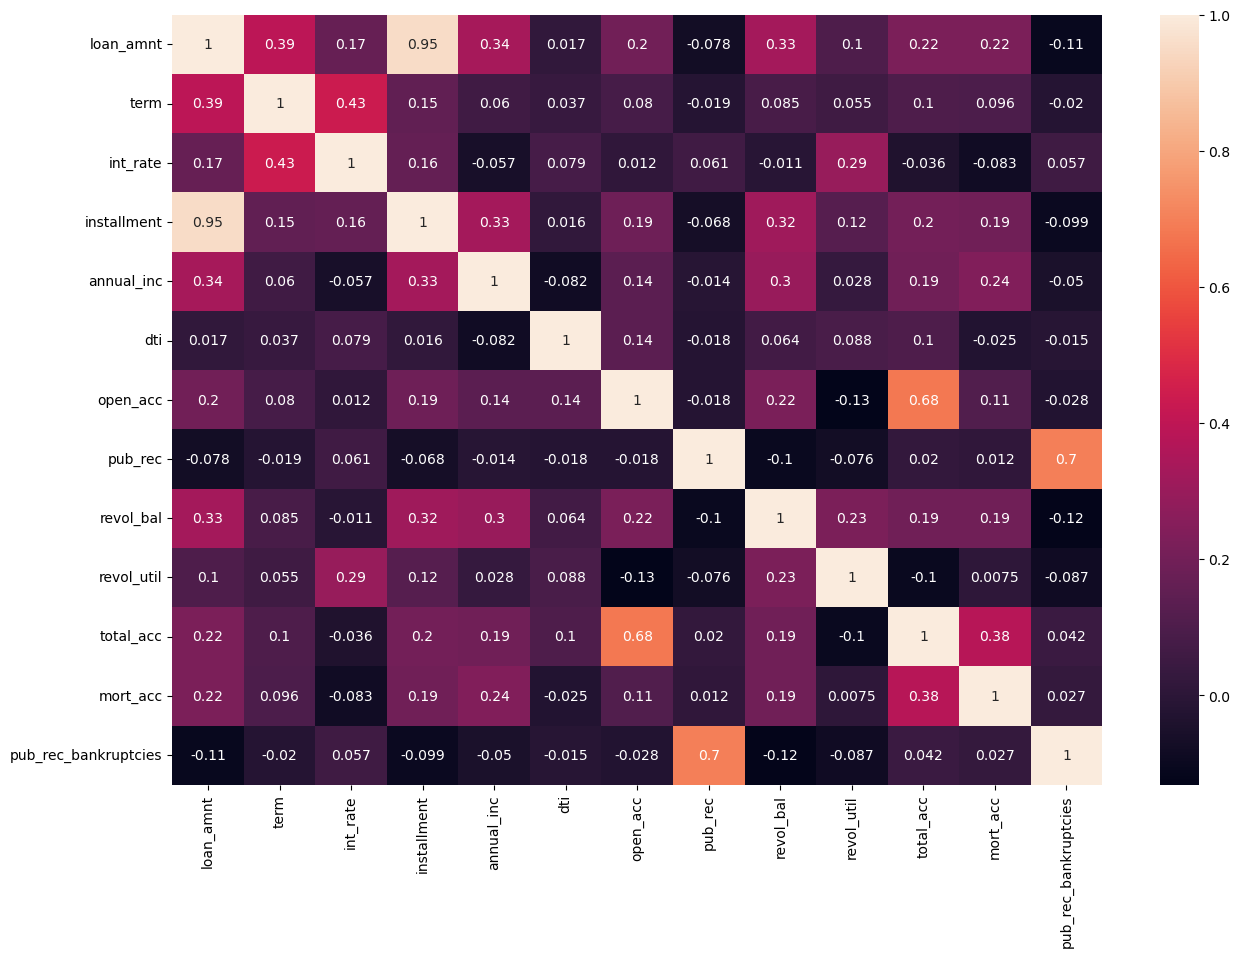

In [297]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True)
plt.show()

1. Loan amount and installment are having very high coorelation so we will drop one.(>=0.7)
2. pub_rec_bankruptcies and pub_rec are having very high corelation so we will drop one.(>=0.7)

In [298]:
#checking for categorical variable
df.select_dtypes(include = 'object').head()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
0,B,B4,Marketing,10+ years,RENT,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,Jun-1990,w,INDIVIDUAL,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,B,B5,Credit analyst,4 years,MORTGAGE,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,Jul-2004,f,INDIVIDUAL,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,B,B3,Statistician,< 1 year,RENT,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,Aug-2007,f,INDIVIDUAL,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,A,A2,Client Advocate,6 years,RENT,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,Sep-2006,f,INDIVIDUAL,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,C,C5,Destiny Management Inc.,9 years,MORTGAGE,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,Mar-1999,f,INDIVIDUAL,"679 Luna Roads\r\nGreggshire, VA 11650"


In [299]:
df['grade'].value_counts()

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

lets check the significance of features with the traget varaibale with help of hypothesis testing

In [300]:
from scipy.stats import ttest_ind, chi2_contingency, levene

def feature_significance_test(df, target_column):
    numerical_cols = df.select_dtypes(exclude = 'object').columns
    categorical_cols = df.select_dtypes(include = 'object').columns.drop(target_column)
    
    results = []
    
    labels = df[target_column].dropna().unique()
    if len(labels) != 2:
        raise ValueError(f"Target column {target_columns} must have exactly 2 unique values.")
        
    label1 , label2 = labels[0], labels[1]
    
    for col in numerical_cols:
        group1 = df.loc[df[target_column] == label1, col].dropna()
        group2 = df.loc[df[target_column] == label2 , col].dropna()
        
        
        if len(group1) < 2 or len(group2) < 2:
            continue
        if group1.nunique() <= 1 or group2.nunique() <=1:
            continue
            
        _, levene_p = levene(group1, group2)
        equal_var = levene_p >= 0.05
        
        t_stat, p_val = ttest_ind(group1, group2, equal_var = equal_var)
        
        results.append({
            'feature' : col,
            'test' : 't_test (Welch)' if not equal_var else 't_test (Student)',
            'levene_p' : levene_p,
            'p-value' : p_val,
            'equal_var' : equal_var
        })
        
    for col in categorical_cols:
        contigency_table = pd.crosstab(df[target_column], df[col])
        if contigency_table.shape[0] < 2 or contigency_table.shape[1] < 2:
            continue
        chi2, p, dof, expected = chi2_contingency(contigency_table)
        results.append({
            'feature': col,
            'test' : 'Chi2',
            'p-value' : p,
            'dof' : dof
        })
        
    result_df = pd.DataFrame(results)
    result_df['significant'] = result_df['p-value'] < 0.05
    
    
    return result_df.sort_values('p-value', na_position = 'last')
            

In [301]:
sig_features = feature_significance_test(df, 'loan_status')
sig_features

,feature,test,levene_p,p-value,equal_var,dof,significant
1,term,t_test (Welch),0.000000e+00,0.000000e+00,False,NaN,True
2,int_rate,t_test (Welch),5.742075e-14,0.000000e+00,False,NaN,True
19,issue_d,Chi2,NaN,0.000000e+00,NaN,114.0,True
18,verification_status,Chi2,NaN,0.000000e+00,NaN,2.0,True
17,home_ownership,Chi2,NaN,0.000000e+00,NaN,5.0,True
14,sub_grade,Chi2,NaN,0.000000e+00,NaN,34.0,True
9,revol_util,t_test (Welch),3.079872e-83,0.000000e+00,False,NaN,True
11,mort_acc,t_test (Welch),5.657057e-219,0.000000e+00,False,NaN,True
13,grade,Chi2,NaN,0.000000e+00,NaN,6.0,True
0,loan_amnt,t_test (Welch),3.984622e-48,1.064723e-300,False,NaN,True


In [302]:
#dropping the features where there is not significnace
df_copy = df.copy()
df_copy.drop(['address', 'title'], axis = 1, inplace = True)
df_copy.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

/var/folders/px/pgmdxsdx4pn1kz0hnhdbsg740000gn/T/ipykernel_46184/1535362622.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_copy.corr(), annot = True)


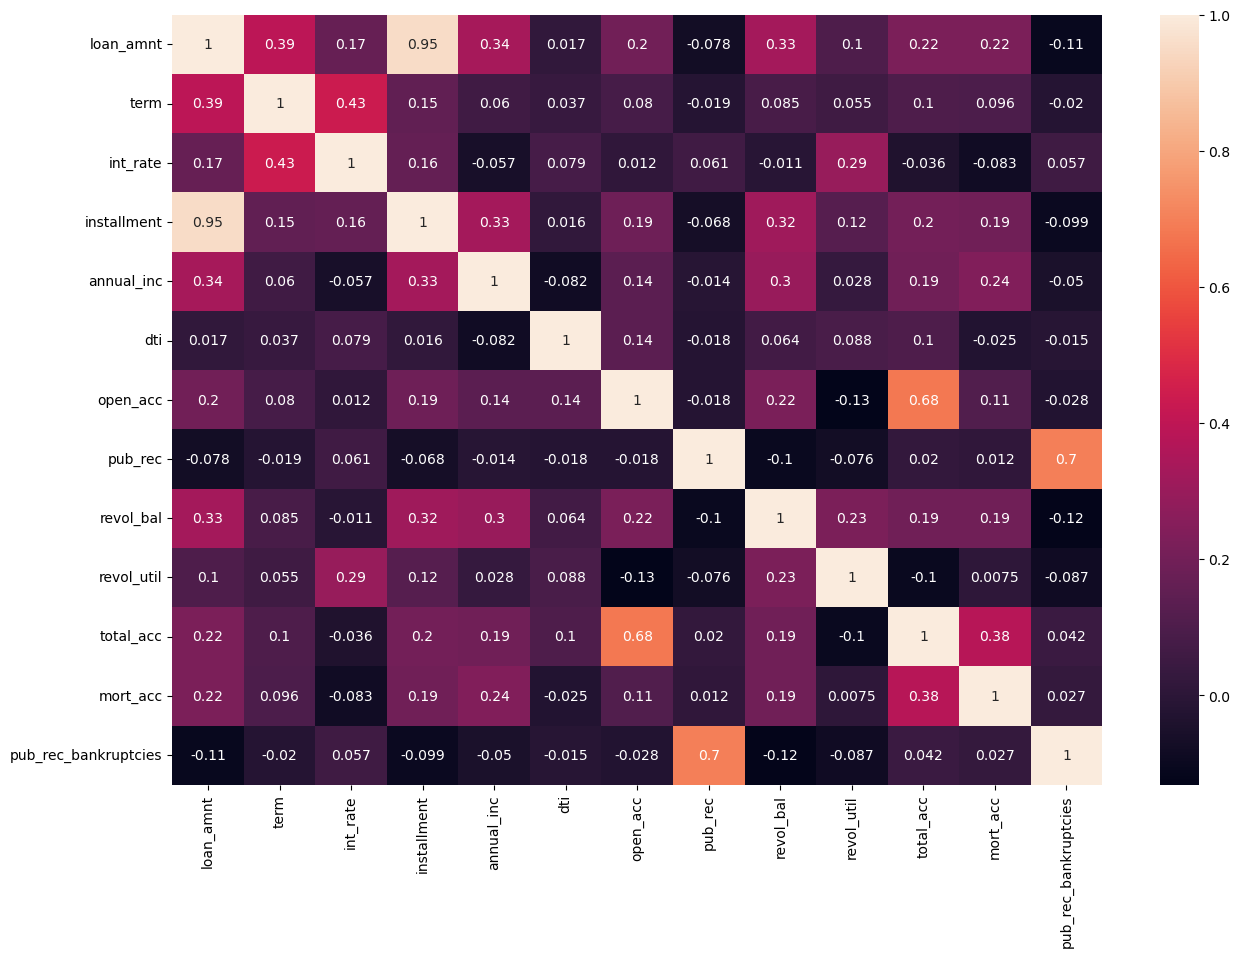

In [303]:
plt.figure(figsize = (15,10))
sns.heatmap(df_copy.corr(), annot = True)
plt.show()

In [304]:
#dropping the columns with high correlation
df_copy.drop(['installment', 'pub_rec'], axis = 1, inplace = True)

/var/folders/px/pgmdxsdx4pn1kz0hnhdbsg740000gn/T/ipykernel_46184/1535362622.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_copy.corr(), annot = True)


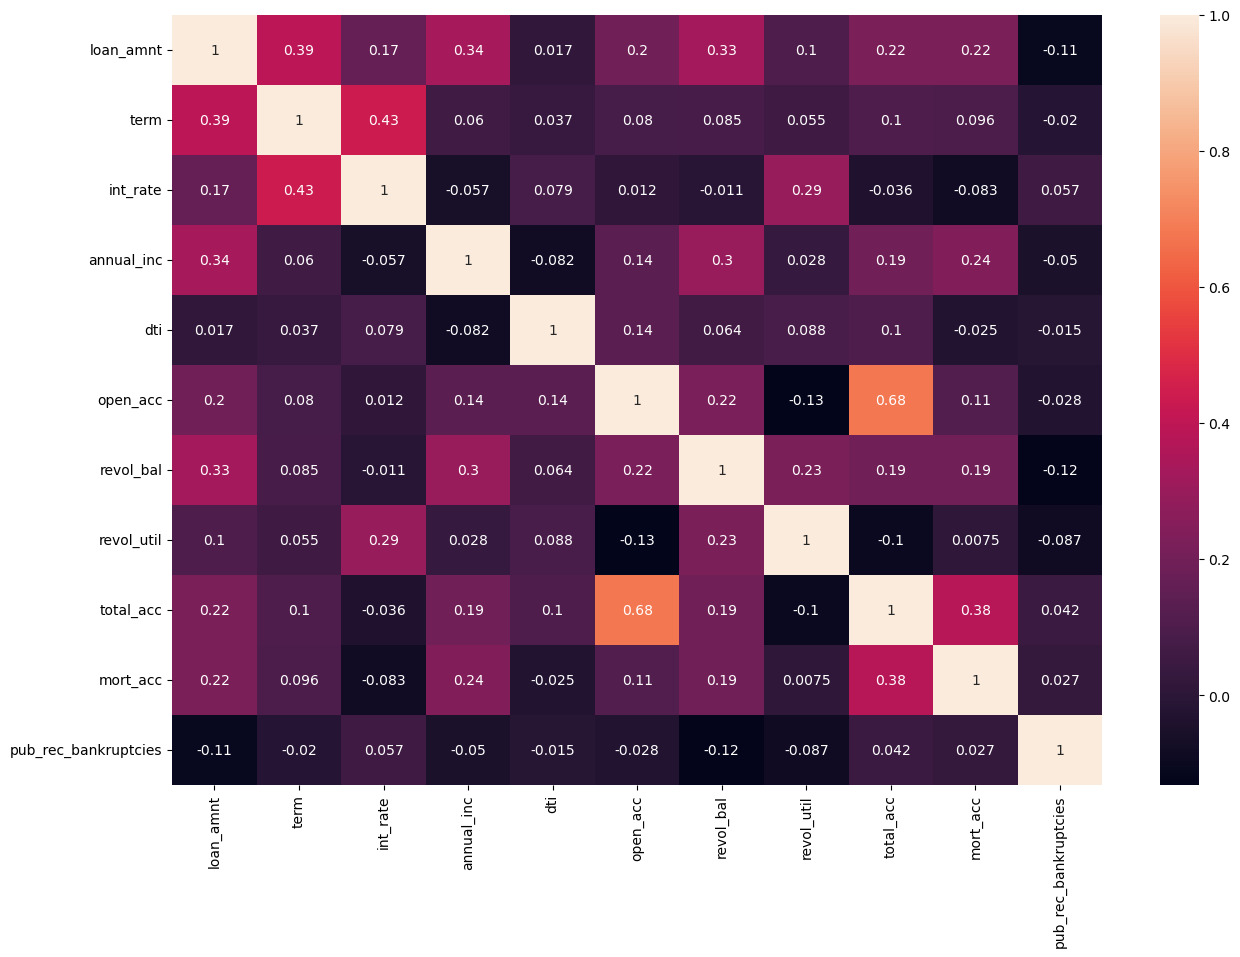

In [305]:
plt.figure(figsize = (15,10))
sns.heatmap(df_copy.corr(), annot = True)
plt.show()

In [306]:
#checking the duplicates
df_copy.duplicated().sum()

0

In [307]:
#handeling the null values
df_copy.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [308]:
df_copy['emp_title'] = df_copy['emp_title'].fillna('other').str.lower().str.strip()

In [309]:
df_copy.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
grade                       0
sub_grade                   0
emp_title                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
open_acc                    0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [310]:
#for emp_lenght we are filling null values assuming it has 0 years
df_copy['emp_length'] = df_copy['emp_length'].fillna('0 year')

In [311]:
# for revolving line utilization rate we are filling missing values with the median
df_copy['revol_util'] = df_copy['revol_util'].fillna(df_copy['revol_util'].median())

In [312]:
#imputing the missing value based on average mort_acc per total_acc group
mort_acc_mean = df_copy.groupby('total_acc')['mort_acc'].mean()

In [313]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return mort_acc_mean[total_acc]
    else:
        return mort_acc
    
df_copy['mort_acc'] = df_copy.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis = 1)

In [314]:
#simply filling the missing value with 0
df_copy['pub_rec_bankruptcies']= df_copy['pub_rec_bankruptcies'].fillna(0)

In [315]:
df_copy.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
dtype: int64

In [316]:
df_copy[num_cols].nunique().sort_values()

term                        2
pub_rec_bankruptcies        9
open_acc                   61
mort_acc                  110
total_acc                 118
int_rate                  566
revol_util               1226
loan_amnt                1397
dti                      4262
annual_inc              27197
revol_bal               55622
dtype: int64

In [317]:
import numpy as np
import pandas as pd

def handle_outliers(df):

    # Columns NOT to apply outlier removal
    skip_cols = ['term', 'pub_rec_bankruptcies']


    # Columns for standard IQR outlier removal
    num_cols = df.select_dtypes(include=np.number).columns

    iqr_cols = [
        col for col in num_cols
        if col not in skip_cols
    ]


    for col in iqr_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower) & (df[col] <= upper)]

    return df


In [318]:
df_copy = handle_outliers(df_copy)

Axes(0.125,0.11;0.775x0.77)


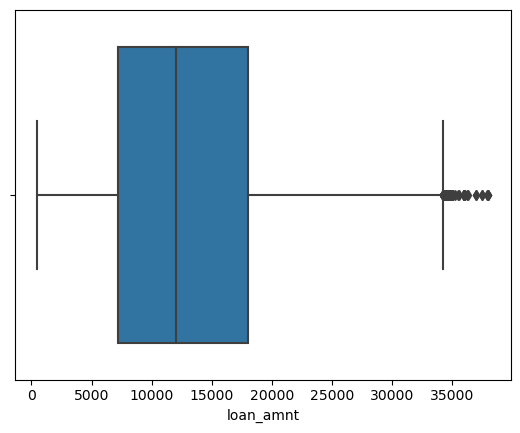

Axes(0.125,0.11;0.775x0.77)


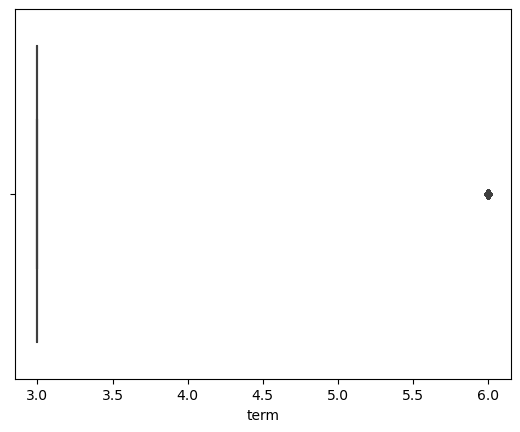

Axes(0.125,0.11;0.775x0.77)


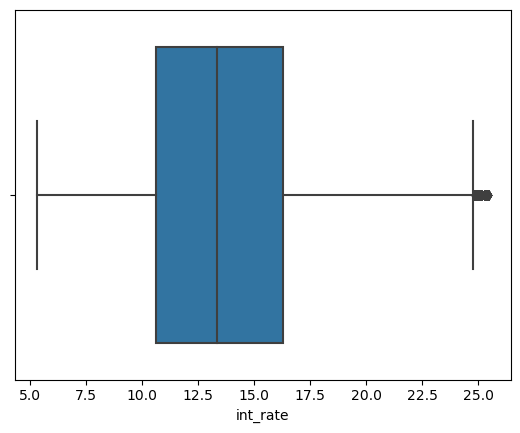

Axes(0.125,0.11;0.775x0.77)


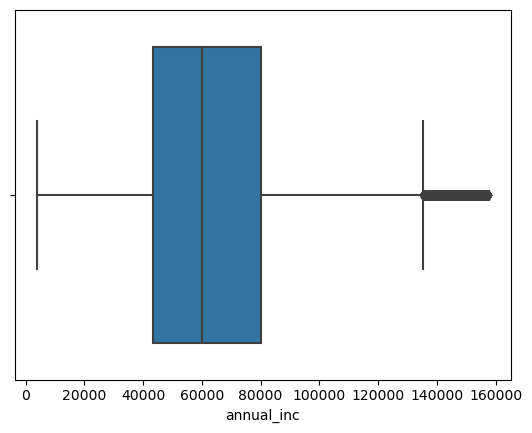

Axes(0.125,0.11;0.775x0.77)


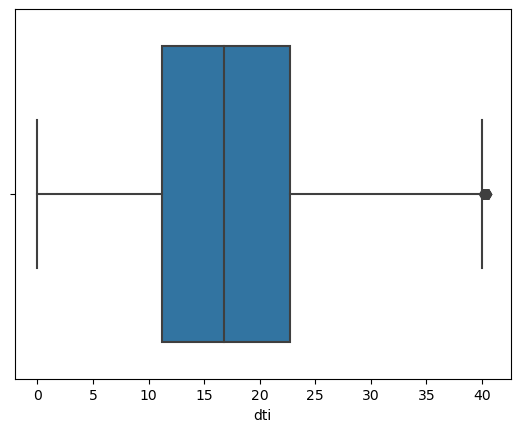

Axes(0.125,0.11;0.775x0.77)


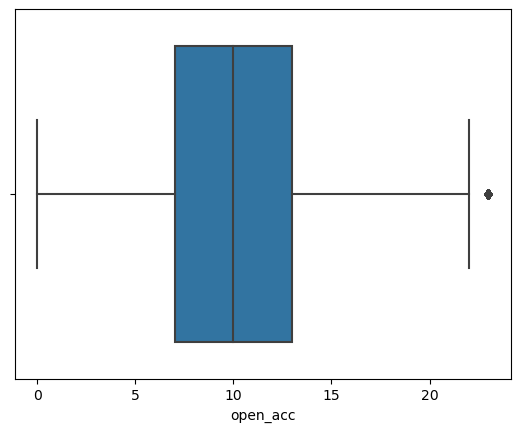

Axes(0.125,0.11;0.775x0.77)


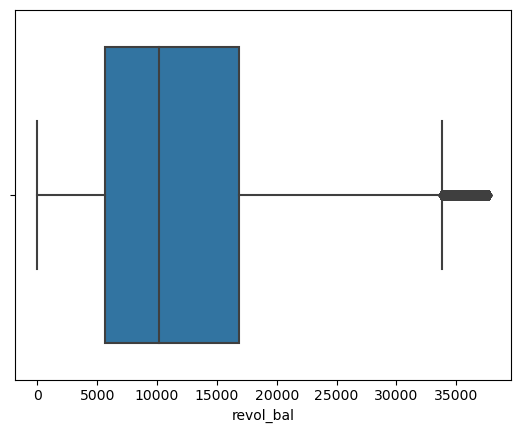

Axes(0.125,0.11;0.775x0.77)


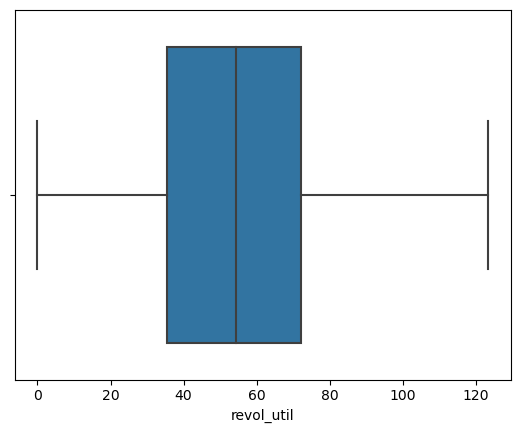

Axes(0.125,0.11;0.775x0.77)


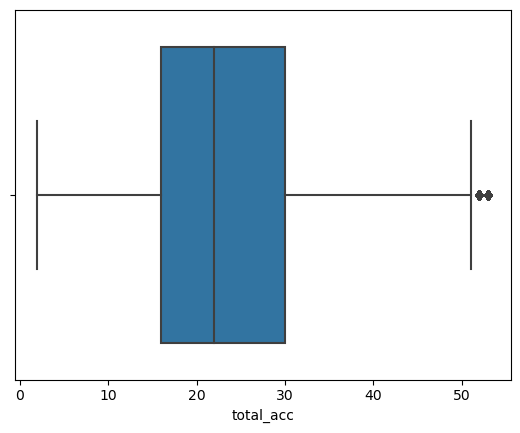

Axes(0.125,0.11;0.775x0.77)


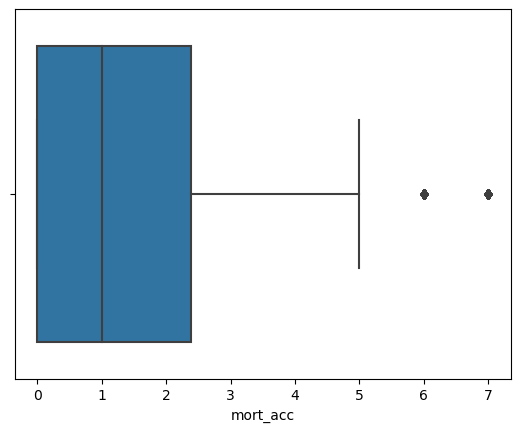

Axes(0.125,0.11;0.775x0.77)


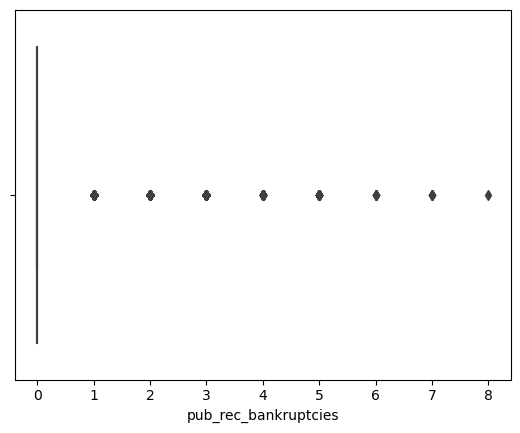

In [319]:
for cols in num_cols:
    print(sns.boxplot(x = df_copy[cols]))
    plt.show()

So we have remove some of the outliers

In [320]:
df_copy.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,10000.0,3,11.44,B,B4,marketing,10+ years,RENT,117000.0,Not Verified,...,26.24,Jun-1990,16.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0
1,8000.0,3,11.99,B,B5,credit analyst,4 years,MORTGAGE,65000.0,Not Verified,...,22.05,Jul-2004,17.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0
2,15600.0,3,10.49,B,B3,statistician,< 1 year,RENT,43057.0,Source Verified,...,12.79,Aug-2007,13.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0
3,7200.0,3,6.49,A,A2,client advocate,6 years,RENT,54000.0,Not Verified,...,2.60,Sep-2006,6.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0
4,24375.0,6,17.27,C,C5,destiny management inc.,9 years,MORTGAGE,55000.0,Verified,...,33.95,Mar-1999,13.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0


In [321]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338436 entries, 0 to 396029
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             338436 non-null  float64
 1   term                  338436 non-null  int64  
 2   int_rate              338436 non-null  float64
 3   grade                 338436 non-null  object 
 4   sub_grade             338436 non-null  object 
 5   emp_title             338436 non-null  object 
 6   emp_length            338436 non-null  object 
 7   home_ownership        338436 non-null  object 
 8   annual_inc            338436 non-null  float64
 9   verification_status   338436 non-null  object 
 10  issue_d               338436 non-null  object 
 11  loan_status           338436 non-null  object 
 12  purpose               338436 non-null  object 
 13  dti                   338436 non-null  float64
 14  earliest_cr_line      338436 non-null  object 
 15  

In [322]:
#creating the model only with numerical columns first to check the performance

from sklearn.model_selection import train_test_split

In [323]:
df_copy[num_cols]

,loan_amnt,term,int_rate,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.0,3,11.44,117000.0,26.24,16.0,36369.0,41.8,25.0,0.000000,0.0
1,8000.0,3,11.99,65000.0,22.05,17.0,20131.0,53.3,27.0,3.000000,0.0
2,15600.0,3,10.49,43057.0,12.79,13.0,11987.0,92.2,26.0,0.000000,0.0
3,7200.0,3,6.49,54000.0,2.60,6.0,5472.0,21.5,13.0,0.000000,0.0
4,24375.0,6,17.27,55000.0,33.95,13.0,24584.0,69.8,43.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
396024,6000.0,3,13.11,64000.0,10.81,7.0,11456.0,97.1,9.0,0.000000,0.0
396025,10000.0,6,10.99,40000.0,15.63,6.0,1990.0,34.3,23.0,0.000000,0.0
396027,5000.0,3,9.99,56500.0,17.56,15.0,32704.0,66.9,23.0,0.000000,0.0
396028,21000.0,6,15.31,64000.0,15.88,9.0,15704.0,53.8,20.0,5.000000,0.0


In [324]:
#mapping the target column
df_copy['loan_status'] = df_copy['loan_status'].map({'Fully Paid' : 0, 'Charged Off' : 1})
df_copy['loan_status'].value_counts()

0    271942
1     66494
Name: loan_status, dtype: int64

In [325]:
num_df_copy = df_copy.drop(df_copy.select_dtypes(include = 'object'), axis = 1)

In [326]:
X = num_df_copy.drop('loan_status', axis = 1)
y = num_df_copy['loan_status']

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, random_state = 42)

In [328]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(253827, 11)
(253827,)
(84609, 11)
(84609,)


In [253]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [329]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [330]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

LogisticRegression()

In [331]:
y_pred = model_1.predict(X_test)

In [335]:
from sklearn.metrics import accuracy_score , classification_report
print('Accuracy :', accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

Accuracy : 0.8066281364866622
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     82634
           1       0.06      0.53      0.11      1975

    accuracy                           0.81     84609
   macro avg       0.52      0.67      0.50     84609
weighted avg       0.96      0.81      0.87     84609



In [340]:
#checking for imbalance 
(df_copy['loan_status'].value_counts() / df_copy.shape[0]) * 100

#data is imbalance
#we will use class weights to balance the data while model building.

0    80.352563
1    19.647437
Name: loan_status, dtype: float64

In [342]:
df_copy.select_dtypes(include = 'object').head()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,purpose,earliest_cr_line,initial_list_status,application_type
0,B,B4,marketing,10+ years,RENT,Not Verified,Jan-2015,vacation,Jun-1990,w,INDIVIDUAL
1,B,B5,credit analyst,4 years,MORTGAGE,Not Verified,Jan-2015,debt_consolidation,Jul-2004,f,INDIVIDUAL
2,B,B3,statistician,< 1 year,RENT,Source Verified,Jan-2015,credit_card,Aug-2007,f,INDIVIDUAL
3,A,A2,client advocate,6 years,RENT,Not Verified,Nov-2014,credit_card,Sep-2006,f,INDIVIDUAL
4,C,C5,destiny management inc.,9 years,MORTGAGE,Verified,Apr-2013,credit_card,Mar-1999,f,INDIVIDUAL


In [377]:
df_copy['application_type'].value_counts()

INDIVIDUAL    338087
JOINT            308
DIRECT_PAY        41
Name: application_type, dtype: int64

In [361]:
#encoding the grade in order of risk
df_copy['grade_encoded'] = df_copy['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F':6, 'G':7})

In [357]:
sub_grade_order = [
    'A1','A2','A3','A4','A5',
    'B1','B2','B3','B4','B5',
    'C1','C2','C3','C4','C5',
    'D1','D2','D3','D4','D5',
    'E1','E2','E3','E4','E5',
    'F1','F2','F3','F4','F5',
    'G1','G2','G3','G4','G5'
]

sub_grade_map = {grade: idx + 1 for idx, grade in enumerate(sub_grade_order)}
df_copy['sub_grade_encoded'] = df_copy['sub_grade'].map(sub_grade_map)

In [364]:
#one hot encoding for purpose
df_copy = pd.get_dummies(df_copy, columns=['purpose'], drop_first=True)

In [372]:
#one hot encoding for verification_status
df_copy = pd.get_dummies(df_copy, columns = ['verification_status'], drop_first = True)

In [375]:
#one hot encoding with grouping the rare category of howe_ownership
df_copy['home_ownership'] = df_copy['home_ownership'].replace(['OTHER', 'NONE', 'ANY'], 'OTHER_CATEGORY')
df_copy = pd.get_dummies(df_copy, columns = ['home_ownership'], drop_first = True)

In [378]:
#one hot encoding with grouping the rare category of application_type
df_copy['application_type'] = df_copy['application_type'].replace(['JOINT', 'DIRECT_PAY'], 'OTHER_TYPE')
df_copy = pd.get_dummies(df_copy, columns = ['application_type'], drop_first = True)

In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [389]:
#storing the numerical features
num_cols = df_copy.select_dtypes(exclude = 'object').columns

In [394]:
X = df_copy[num_cols].drop('loan_status', axis = 1)
y = df_copy[num_cols]['loan_status']

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [396]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [398]:
model = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [400]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     68149
           1       0.32      0.63      0.42     16460

    accuracy                           0.66     84609
   macro avg       0.60      0.65      0.59     84609
weighted avg       0.77      0.66      0.70     84609



In [406]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

model = Pipeline([
    ('scaler' , StandardScaler()),
    ('smote' , SMOTE()),
    ('log_reg' , LogisticRegression(max_iter = 2000))
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('log_reg', LogisticRegression(max_iter=2000))])

In [407]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     68149
           1       0.32      0.64      0.42     16460

    accuracy                           0.66     84609
   macro avg       0.60      0.65      0.59     84609
weighted avg       0.77      0.66      0.69     84609



In [409]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresolds = roc_curve(y_test, y_proba)


ROC AUC Score: 0.7047527817994832


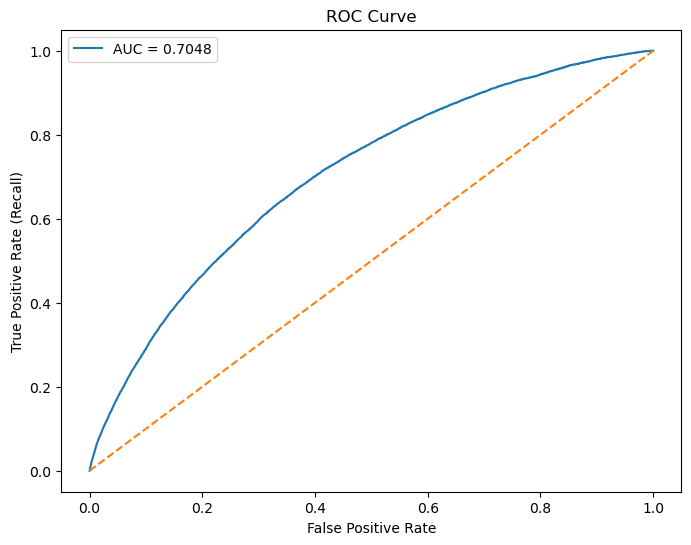

In [410]:
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc)


plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label = f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

Precision Recall Score: 0.7047527817994832


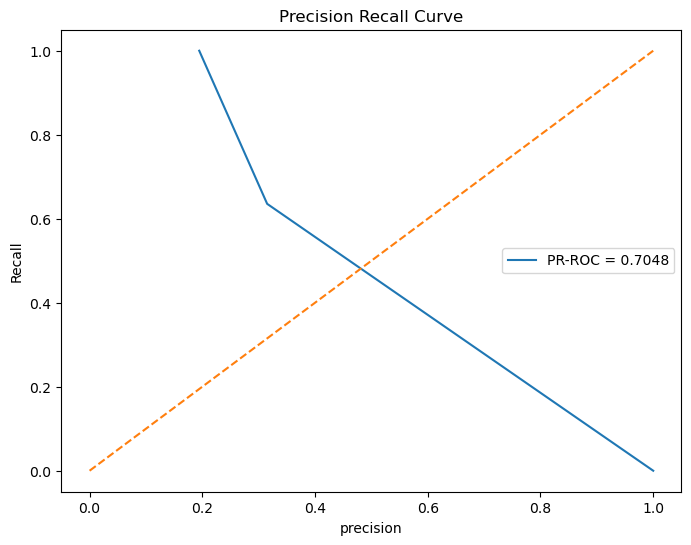

In [412]:
from sklearn.metrics import precision_recall_curve

y_scores = model.predict_proba(X_test)[:, 1]
precision, recall , threshold = precision_recall_curve(y_test, y_pred)

print("Precision Recall Score:", auc)


plt.figure(figsize = (8,6))
plt.plot(precision, recall, label = f"PR-ROC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel("precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend()
plt.show()

In [415]:
confusion_matrix(y_test, y_pred)

array([[45412, 22737],
       [ 6001, 10459]])

In [416]:
#creating some more features
df_copy['loan_income_ratio'] = df_copy['loan_amnt'] / (df_copy['annual_inc'] + 1)
df_copy['dti_int_rate'] = df_copy['dti'] * df_copy['int_rate']
df_copy['revol_bal_per_acc'] = df_copy['revol_bal'] / (df_copy['open_acc'] + 1)
df_copy['credit_utilization'] = df_copy['revol_util'] * df_copy['total_acc']

In [419]:
df_copy.drop(['grade', 'sub_grade'], axis = 1, inplace = True)

In [427]:
df_copy.drop('emp_title', axis = 1, inplace = True)

In [431]:
def emp_length_encoded(x):
    if x == "10+ years":
        return 10
    if x in ["< 1 year", "0 year"]:
        return 0
    return int(x.split()[0])

df_copy["emp_length_encoded"] = df_copy["emp_length"].apply(emp_length_encoded)

In [434]:
df_copy.drop('emp_length', axis = 1, inplace = True)

In [439]:
#dropping the initial_list_status as it's not very important for the prediction
df_copy.drop('initial_list_status', axis = 1, inplace = True)

In [446]:
#changing the features into the datetime format
df_copy["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y")
df_copy["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")

In [447]:
#creating a feature with the help of issue date and earliest credit line date
reference = df_copy['issue_d']
df_copy["credit_history_length"] = (reference - df_copy["earliest_cr_line"]).dt.days / 365

In [456]:
#extracting the date and month from issue_date
df_copy['issue_month'] = df_copy["issue_d"].dt.month
df_copy['issue_date'] = df_copy["issue_d"].dt.year

In [457]:
#dropping the datetime columns
df_copy.drop(['issue_d', 'earliest_cr_line'], axis = 1, inplace = True)

In [461]:
X = df_copy.drop('loan_status', axis = 1)
y = df_copy['loan_status']

In [462]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [464]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler' , StandardScaler()),
    ('clf', LogisticRegression(max_iter = 1000, class_weight = 'balanced'))
])

In [475]:
param_grid = {'clf_C' : [0.001,0.01,0.1,1,10]}

In [476]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe,
                   param_grid,
                   cv = 5,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   verbose = 2)



In [480]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1, param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='roc_auc', verbose=2)

In [482]:
print('Best Parameters: ', grid.best_params_)
print('Best CV AUC:', grid.best_score_)

best_model = grid.best_estimator_

Best Parameters:  {'clf__C': 10}
Best CV AUC: 0.711307038564749


In [483]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.88      0.67      0.76     54515
           1       0.32      0.64      0.42     13173

    accuracy                           0.66     67688
   macro avg       0.60      0.65      0.59     67688
weighted avg       0.77      0.66      0.69     67688

Test ROC-AUC: 0.7072415381312666
[CV] END ................clf__C=0.001, clf__solver=liblinear; total time=   4.7s
[CV] END .....................clf__C=0.01, clf__solver=lbfgs; total time=   1.8s
[CV] END .....................clf__C=0.01, clf__solver=lbfgs; total time=   1.9s
[CV] END ......................clf__C=0.1, clf__solver=lbfgs; total time=   1.8s
[CV] END ......................clf__C=0.1, clf__solver=lbfgs; total time=   1.7s
[CV] END ....................clf__C=1, clf__solver=liblinear; total time=   5.6s
[CV] END .......................clf__C=10, clf__solver=lbfgs; total time=   1.6s
[CV] END .......................................clf__C=0.001; total time=

# Business Insights From the Final Model

    - This Logistic Regression model achieved an ROC-AUC of ~0.71, which indicates the model can correctly differentiate good vs. risky borrowers about 70% of the time.
    - In financial risk modeling, anything above 0.70 is considered reasonably strong, especially for a linear model.
   
   
# The model is effective at identifying customers likely to default

    - The recall for defaulted customers (class 1) is 0.64.
    - This means model catched 64% of high risk loan applicants.
    
    - Missing a defaulter (false negative) is far more costly than incorrectly flagging someone.
    - So a recall of 64% contributes to reduced credit losses.
    
# There is a trade-off: More false positives (low precision)

    - Precision for defaulters is 0.32, meaning:
           - Only 32% of customers predicted as high-risk actually turn out to default.
    This results in:
       - More customers being flagged as "risky" than necessary.
       - Potentially fewer good customers being approved.
       - But this is expected when the goal is minimizing financial loss rather than maximizing approvals.
       - The model leans toward risk-avoidance rather than profitability optimization.
        
        
# Model accuracy isn’t very meaningful because the data is imbalanced
      
    - Overall accuracy is 0.66, but this is not a key metric here.
    - With a dataset where most customers are non-defaulters, high accuracy can be misleading.